# Data Generating Process

In this section I am creating the sample data according to a *true* model of my creation. Consider the simple two equation model

\begin{align}
Y &= \beta X + e \\
X &= \pi Z + v
\end{align}


All variables are scalars for simplicity. 

The variables $X$ and $Y$ are generated given the following information:

* $Z \sim N(0,1)$

* $u:=
    \begin{pmatrix}
    e \\ v
    \end{pmatrix}
    \sim 
    N
    \begin{pmatrix}
    \begin{pmatrix}
    0 \\ 0
    \end{pmatrix}
    , 
    \begin{pmatrix}
    1 & \rho \\ \rho & 1
    \end{pmatrix}
    \end{pmatrix}$
    
* We let the coefficient $\beta$ vary over the interval $[-2, 2]$ in discrete and small steps.

* For $\pi$ it can be shown that $R^2 = (\widehat{\text{Corr}}(X,Z))^2 = s_{XZ}^2/s_{X}^2 = \hat{\pi}^2/(1+\hat{\pi}^2)$ and therefore
    $$ \hat{\pi} = \sqrt{R^2/(1-R^2)}$$
    
 Aside: For the simple linear regression model $F=N \cdot R^2/(1-R^2)$ which suggests the following relationship between the first stage $F$ and the coefficient $\pi$: 
$$F \approx N \cdot \hat{\pi}^2 $$
So by setting $\pi$ and $N$ we effictively govern the $F$ in the first stage regression of $X$ on $Z$.

In [1]:
# loading modules
using LinearAlgebra
import LinearAlgebra.cholesky
using Seaborn
using Statistics

In [2]:
# defining containers to store results
struct Estimator
    bhat::Real
    se::Real
    tstat::Real
end

struct Parameters
    N::Int64
    beta::Float64
    F::Float64
    rho::Float64
end

struct Dgp
    x::AbstractVector
    y::AbstractVector
    z::AbstractVector
end

struct Simresults
    dist::AbstractVector
    power::Float64
end

In [3]:
function estimate(X::AbstractVector, Y::AbstractVector, Z::AbstractVector)

    # note: if you call the function with
    # estimate(x,y,x) it will do OLS
    # estimate(x,y,z) it will do IV
    
    bhat = Z'Y/(Z'X)
    res = Y - X*bhat
    shat = res'res/length(res)
    omegahat = shat * (inv(Z'X) * (Z'Z) * inv(X'Z))
    
    stderr = sqrt(omegahat)
    tstat = abs(bhat/stderr)

    # sending results
    Estimator(bhat, stderr, tstat)

end

estimate (generic function with 1 method)

In [4]:
function dgp(parms::Parameters)
    
    # first stage coefficient
    # pie = sqrt(parms.r2/(1-parms.r2))
       
    # exogenous variables
    C = cholesky([1 parms.rho; parms.rho 1])
    u = [randn(parms.N,1) randn(parms.N,1)] * C.U;
        
    e = u[:,1]
    v = u[:,2] 
    Z = randn(parms.N)
    
    # creating endogenous variables    
    pie = sqrt(parms.F/parms.N)
    X = pie * Z + v
    Y = parms.beta * X + e
    
    # sending results
    Dgp(X, Y, Z)
end

dgp (generic function with 1 method)

In [5]:
function simulate(parms::Parameters, reps::Int64=2000)
    
    bvec = zeros(reps)
    pow = 0
    
    for r = 1:reps
        sample = dgp(parms)
        b = estimate(sample.x, sample.y, sample.z)
        
        bvec[r] = b.bhat
        pow = pow + (b.tstat>1.96)
    
    end
    
    # sending results
    Simresults(bvec, pow/reps)
end

simulate (generic function with 2 methods)

In [6]:
function power(parms::Parameters, betarange=(-2:0.1:2))

    powerfunc = zeros(length(betarange))
    count = 1

    for b in betarange
        parmsnew = Parameters(parms.N, b, parms.F, parms.rho)
        betas = simulate(parmsnew)

        powerfunc[count] = betas.power
        count += 1
    end
    
    powerfunc

end

power (generic function with 2 methods)

Set parameters like so:
\begin{align*}
N &\in \lbrace 100, 1000 \rbrace \\
\beta &= 0 \\
\pi &= \sqrt{\frac{F}{N}} \qquad\qquad \text{with }
F \in \lbrace 1, 2, 5, 10, 20 \rbrace\\
\rho &\in \lbrace 0, 0.5, 0.9 \rbrace
\end{align*}

where $R^2$ controls the strength of the instrument (larger values of $R^2$, stronger instrument) and $\rho$ controls the degree of endogeneity ($\rho=0$ no endogneity, $\rho=0.90$ a lot of endogeneity).

# Simulating Distribution of IV Estimator

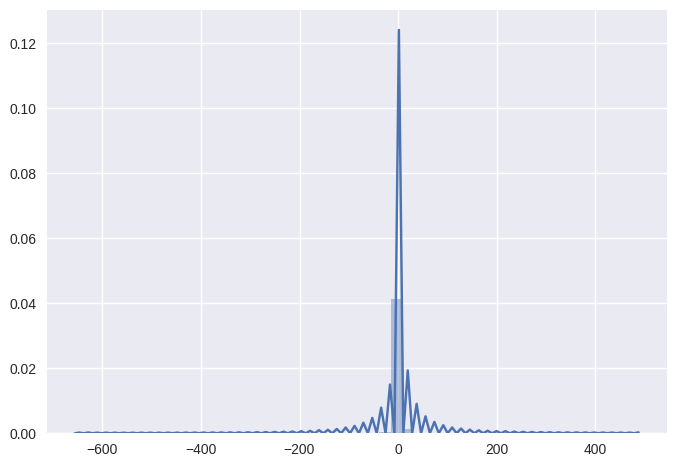

-0.24102852587727996

In [42]:
# order of Parameters(N, beta, F, rho)
parameters = Parameters(1000, 0, 1, 0.99)
betas = simulate(parameters);
distplot(betas.dist)
savefig("./figures/lecture_9_fig1a.eps", format="eps", dpi=1000, facecolor="#fdf6e3")
Bias = mean(betas.dist)

# Computing Actual Power/Size of t-test
Recall that power function is, most generally, the probability of rejecting the null given the true coefficient. 

The default null is: $H_0: \beta = 0$, so we are always testing whether the true coefficient is zero.

At the same time we will vary the true coefficient $\beta$ in the DGP from $-2$ to $+2$. 

This allows us to simulate the statistical power and size. 

\begin{align*}
    Power = \Pr(\text{reject } H_0: \beta_0 = 0 | \text{ true } \beta \neq 0 )\\
    Size  = \Pr(\text{reject } H_0: \beta_0 = 0 | \text{ true } \beta = 0 )
\end{align*}

Of course we want the size to be fixed at 5% while at the same time maximizing the power.




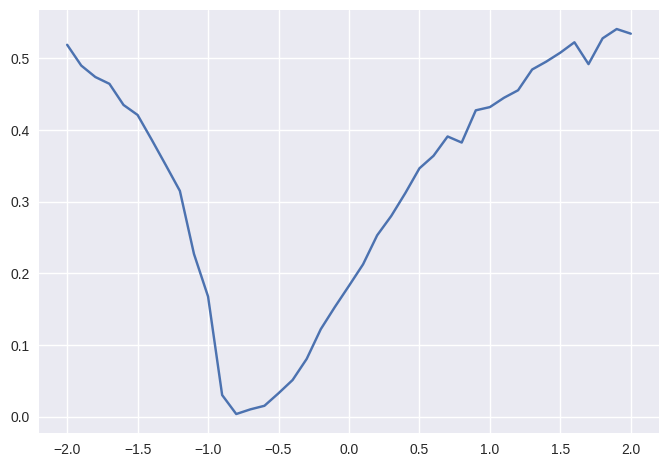

In [43]:
powergraph = power(parameters); 
plot(-2:0.1:2,powergraph)
savefig("./figures/lecture_9_fig1b.eps", format="eps", dpi=1000, facecolor="#fdf6e3")

In [44]:
Actual_size = powergraph[21]

0.1825